In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import os
import numpy as np
import pandas as pd
from torch import nn
from joblib import dump

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from math import floor

from unityagents import UnityEnvironment

from inspect import getsource
import torch
import random
from collections import deque

import colorsys

from drl_nav.utils.utils import seed_all
from drl_nav.utils.context import Context
from drl_nav.config.config import AgentConfiguration
from drl_nav.agent import Agent_PER, Agent_DQN_pixel
from drl_nav.network.heads import LabelizerNet, AuxNet, QNet
from drl_nav.network.bodies import ConvBody

from drl_nav.utils.schedule import LinearSchedule, ExponentialSchedule
from drl_nav.utils.image_utils import to_np_image

____

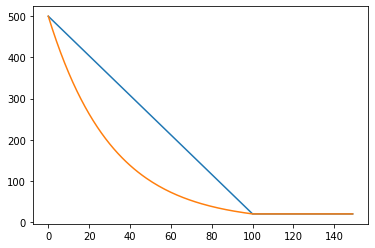

In [2]:
es = ExponentialSchedule(500, 20, 100)
ls = LinearSchedule(500, 20, 100)

plt.plot([ls() for _ in np.arange(150)])
plt.plot([es() for _ in np.arange(150)])

__________

Environment instanciation.

In [3]:
PATH_OUPUT_IMAGE = '../output/image'
_settings = "visual" #'vector' 

banana_path= r"../environment/Banana_Windows_x86_64/Banana.exe"
visual_banana_path= r"../environment/VisualBanana_Windows_x86_64/Banana.exe"

env_path = ''
if _settings == 'vector':
    env_path = banana_path
    _input_type='vector'
    _observations = 'vector_observations'
elif _settings == 'visual':
    env_path = visual_banana_path
    _input_type='image'
    _observations = 'visual_observations'
    
env = UnityEnvironment(
    file_name=env_path,
    #no_graphics=True /!\ not working
)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
env_info = env.reset(train_mode=True)[brain_name]

n_A = brain.vector_action_space_size

print('Environnement setting:', _settings)
print('Number of agents:', len(env_info.agents))
print('Number of actions:', n_A)

# number of actions
if _settings == 'vector':
    vector_state = env_info.vector_observations[0]
    n_S = len(vector_state)
    print("State space:", vector_state.shape)
elif _settings == 'visual':
    visual_state = env_info.visual_observations[0]
    n_S = len(visual_state)
    print("Visual state's shape:", visual_state.shape)

Environnement setting: visual
Number of agents: 1
Number of actions: 4
Visual state's shape: (1, 84, 84, 3)


_____
#### Helper functions


In [5]:
def select_action(last_action, epsilon=0.75):
    """
    Exploratory action selection strategy that favor forward motion and action conservation.
    Actions explanation:
    0: forward
    1: backward
    2: left
    3: right
    """
    if np.random.random() > epsilon:
        action = np.random.choice([0, 1, 2, 3], p=[.5, .1, .2, .2])
    else:
        action = last_action
        
    return action

def count_parameters(model):
    """ return the number of parameters of a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

_____
## Experimentations

###### TODO

- [x]  test image detection like a supervised model.
  
 It is working very well.
  
- [x] Observe the learning curve on the color detection.

With BCELoss instead of CrossEntropyLoss we observe a loss that is quickly falling to $\approx$0.15 (in $\approx$1e4 steps).
   
- [x] use replay buffer both for learning Q values and color detection. (labelizing is costly and labels are often correlated.)
   
- [x] How it evolve when the agent stop working on its color detection ?

At first The skill is slowly forgotten but refresh quite fast.
  
- [x] Validate the DQN Agent on Cartpole.

It is funcitonal

- [X] Seed all experiment and plot quantile of reward funcitons.

Impossible to seed open AI gym environnement

- [X] Decrease the spatial dimension of the input.

from 2888 to 512 while maintaning good bananas detections performances

- Find the easier to validate pixel environment.

- Does the learning of the navigation task keep the banana detection fresh?

- Obviously compare with and without color detection.

- Investiguate on why the DQN loss decrease so rapidly and if it is normal.

- [X] Try Bananas vector.

solved in 200_000 steps

- Vectorize bananas labelization.

- [X] Install Cuda.

- exploration policy favor going forward. Decrease epsilon decreasing.

- increase max step to 400

- Try longer roll out. (TD -3)

- [X] Make labellizer work in batch

gain in performance from 6"30 to 5" for 25 episodes.



**DEV**

- encapsulate all update every X in an object.

### Interactions

##### Interaction with vector environment.

Agent instanciation.

In [43]:
context = Context(
    state_size=n_S,
    action_size=n_A,
    input_type=_input_type
)
config = AgentConfiguration(
    network_body={
        'type': 'dummy',
        'input_size': n_S
    },
    tau=0.01
)

agent = Agent_DQN_pixel(context, config)

Interaction loop.

In [ ]:
%%time

seed_value=1
N_EPISODES = 5_000
MAX_STEP = 400 # native episode of 300 steps
seed_all(seed_value)

errors_color_detection = []
scores = []
scores_by_step = dict()

for i in tqdm(range(1, N_EPISODES + 1)):
    
    env_info = env.reset(train_mode=True)[brain_name]
    state = getattr(env_info, _observations)[0]    
    score, step = 0, 0
    errors_color_detection_episode = []
    
    while True:
        
        action = agent.act(state)
        
        env_info = env.step(action)[brain_name]      
        next_state = getattr(env_info, _observations)[0]
        reward = env_info.rewards[0]                 
        done = env_info.local_done[0]    
        
        agent.step(state, action, reward, next_state, done)
        
        score += reward                               
        state = next_state  
        step += 1

        if (done | (step > MAX_STEP)):
            scores.append(score)
            scores_by_step[agent.t_step] = score
            #errors_color_detection.append(np.mean(errors_color_detection_episode))
            break

100%|██████████| 5000/5000 [1:20:15<00:00,  1.04it/s]

Wall time: 1h 20min 15s


##### Analysis vector interaction

In [150]:
q_values = agent.record_q_values.values()
q_values_np = torch.stack(list(q_values)).numpy()
scores_ = np.array(list(scores_by_step.values()))

xs_complete = np.array(list(agent.record_q_values.keys()))
episode_steps = np.array(list(scores_by_step.keys()))

In [152]:
window_steps = 1_000
window_episodes = 100
max_step = 800_000

max_step_idx = min(np.argwhere(xs_complete >= max_step))[0]
xs = xs_complete[:max_step_idx]
max_episode_idx = min(np.argwhere(episode_steps >= max_step))[0]
x_episode_steps = episode_steps[:max_episode_idx]

rm_mean = (pd.Series(np.mean(q_values_np, axis=1))
             .rolling(window=window_steps).mean()[:max_step_idx])
rm_std = (pd.Series(np.std(q_values_np, axis=1))
            .rolling(window=window_steps).mean()[:max_step_idx])

rm_fwd = (pd.Series(q_values_np[:, 0])
            .rolling(window=window_steps).mean()[:max_step_idx])
rm_fwd_advantage = rm_fwd - rm_mean

rm_bck = (pd.Series(q_values_np[:, 1])
            .rolling(window=window_steps).mean()[:max_step_idx])
rm_bck_advantage = rm_bck - rm_mean

rm_left = (pd.Series(q_values_np[:, 2])
             .rolling(window=window_steps).mean()[:max_step_idx])
rm_left_advantage = rm_left - rm_mean

rm_right = (pd.Series(q_values_np[:, 3]).rolling(window=window_steps).mean()[:max_step_idx])
rm_right_advantage = rm_right - rm_mean

rm_max = (pd.Series(np.max(q_values_np, axis=1))
            .rolling(window=window_steps).mean()[:max_step_idx])
rm_min = (pd.Series(np.min(q_values_np, axis=1))
            .rolling(window=window_steps).mean()[:max_step_idx])

rm_score = (pd.Series(scores_)
            .rolling(window=window_episodes).mean()[:max_episode_idx])

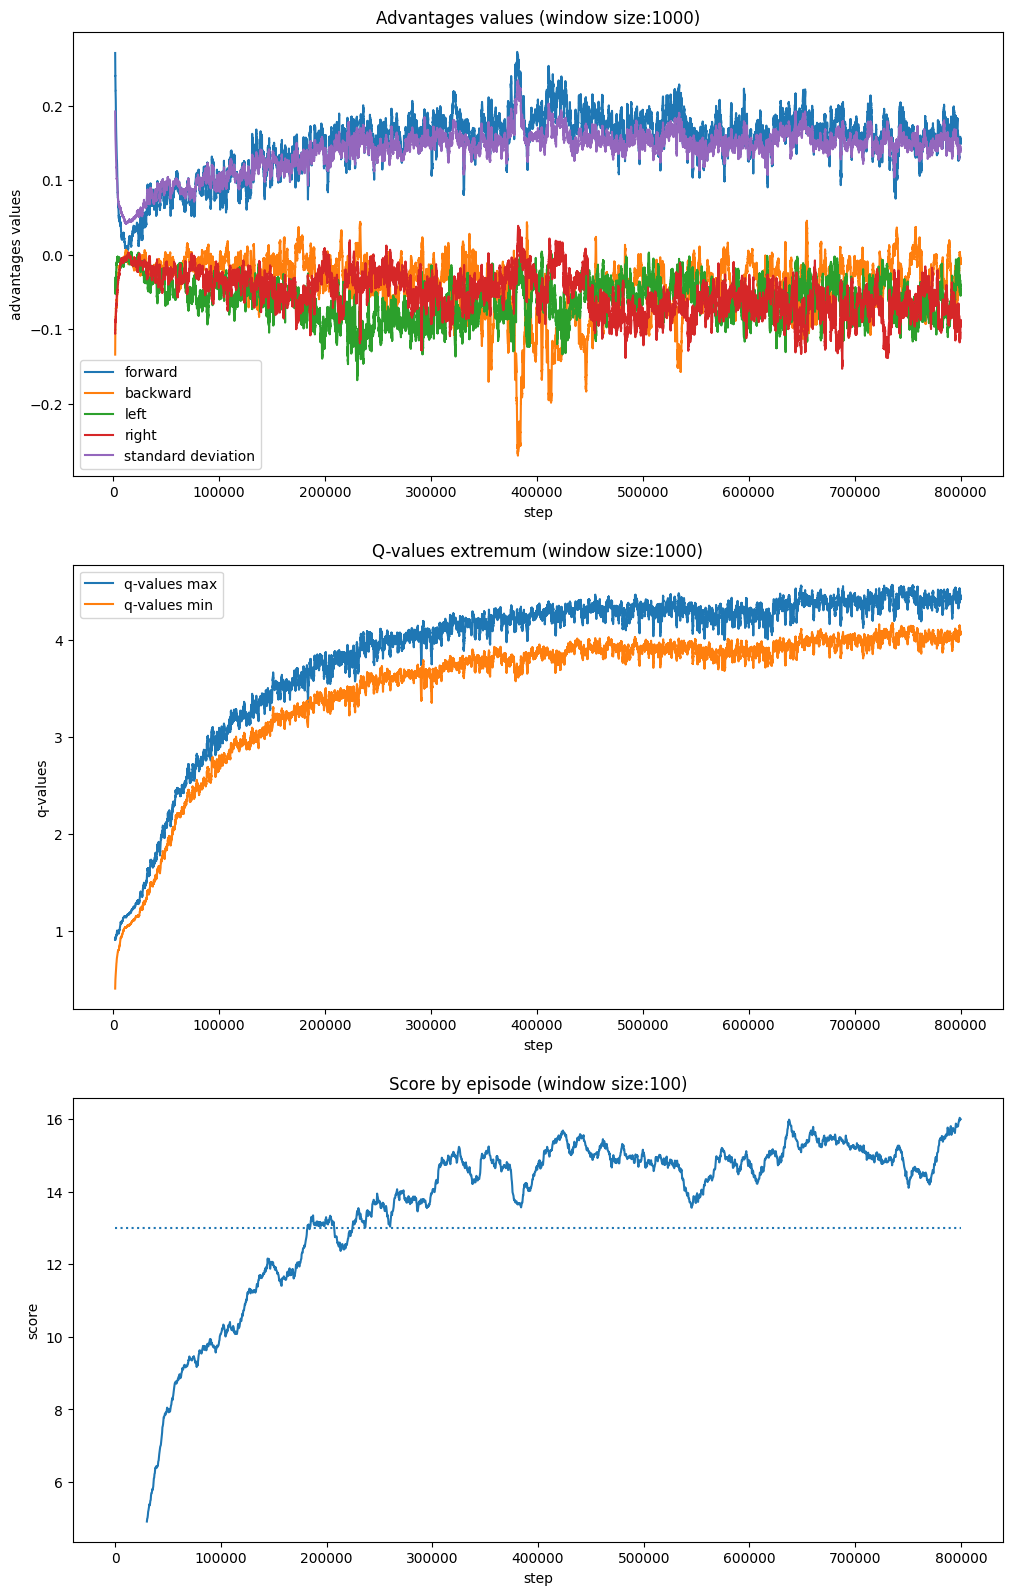

In [159]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,20), dpi=100)

ax1.plot(xs, rm_fwd_advantage, label='forward')
ax1.plot(xs, rm_bck_advantage, label='backward')
ax1.plot(xs, rm_left_advantage, label='left')
ax1.plot(xs, rm_right_advantage, label='right')
ax1.plot(xs, rm_std, label='standard deviation')
ax1.legend()
ax1.set_xlabel('step')
ax1.set_ylabel('advantages values')
ax1.set_title(f'Advantages values (window size:{window_steps})');

ax2.plot(xs, rm_max, label='q-values max')
ax2.plot(xs, rm_min, label='q-values min')
ax2.legend()
ax2.set_xlabel('step')
ax2.set_ylabel('q-values')
ax2.set_title(f'Q-values extremum (window size:{window_steps})');

ax3.plot(x_episode_steps, rm_score)
ax3.hlines(13, xmin=0, xmax=max(x_episode_steps), linestyle=':')
ax3.set_xlabel('step')
ax3.set_ylabel('score')
ax3.set_title(f'Score by episode (window size:{window_episodes})');

_________________
##### Interaction with the visual environment.

In [17]:
dir(config.network_head.device)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'index',
 'type']

In [15]:
context = Context(
    state_size=n_S,
    action_size=n_A,
    input_type=_input_type
)
config = AgentConfiguration(
    tau=0.01
)

agent = Agent_DQN_pixel(context, config)

Device set to cpu
Body to cpu
Body to cpu


Interaction loop

In [10]:
%%time

seed_value=1
N_EPISODES = 5_000
MAX_STEP = 400 # native episode of 300 steps
seed_all(seed_value)

errors_color_detection = []
scores = []
scores_by_step = dict()

for i in tqdm(range(1, N_EPISODES + 1)):
    
    env_info = env.reset(train_mode=True)[brain_name]
    state = getattr(env_info, _observations)[0]    
    score, step = 0, 0
    errors_color_detection_episode = []
    
    while True:
        
        action = agent.act(state)
        
        env_info = env.step(action)[brain_name]      
        next_state = getattr(env_info, _observations)[0]
        reward = env_info.rewards[0]                 
        done = env_info.local_done[0]    
        
        agent.step(state, action, reward, next_state, done)
        
        score += reward                               
        state = next_state  
        step += 1

        if (done | (step > MAX_STEP)):
            scores.append(score)
            scores_by_step[agent.t_step] = score
            #errors_color_detection.append(np.mean(errors_color_detection_episode))
            break

 16%|█▋        | 813/5000 [1:54:32<9:49:53,  8.45s/it] 


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 13107200 bytes.

_____

#### DEBUG

In [ ]:
conv_body()

In [16]:
labelizer = LabelizerNet()

conv_body = ConvBody() # decrease the spatial dimension of the output.
q_net = QNet(conv_body, config.network_head, n_A)
aux_net = AuxNet(conv_body, n_directions=3, n_colors=2)

criterion_q = nn.MSELoss() # MSE
optimizer_q = torch.optim.Adam(q_net.parameters()) # set the learning rate

criterion_aux = nn.CrossEntropyLoss() # CrossEntropy
optimizer_aux = torch.optim.Adam(aux_net.parameters())

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    
print(state.shape)

(1, 84, 84, 3)


In [18]:
count_parameters(conv_body)
count_parameters(aux_net)
count_parameters(q_net)

conv_body.parameters

<bound method Module.parameters of ConvBody(
  (conv1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 6, kernel_size=(5, 5), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1))
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)>

______
#### DEV

____
##### DEBUG

____

In [41]:
%%time

seed_value=1
N_EPISODES = 50 # 5_000
MAX_STEP = 400 # native episode of 300 steps
seed_all(seed_value)

errors_color_detection = []
scores = []
scores_by_step = dict()

for i in tqdm(range(1, N_EPISODES + 1)):
    
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.visual_observations[0]    
    score, step = 0, 0
    #errors_color_detection_episode = []
    
    while True:
        
        action = agent.act(state)
        
        env_info = env.step(action)[brain_name]      
        next_state = env_info.visual_observations[0] 
        reward = env_info.rewards[0]                 
        done = env_info.local_done[0]    
        
        agent.step(state, action, reward, next_state, done)
        
        score += reward                               
        state = next_state  
        step += 1

        if (done | (step > MAX_STEP)):
            scores.append(score)
            scores_by_step[agent.t_step] = score
            #errors_color_detection.append(np.mean(errors_color_detection_episode))
            break

  0%|          | 0/50 [00:00<?, ?it/s]


IndexError: list index out of range

In [ ]:
agent.record_loss_image

In [ ]:
agent.record_loss

______

##### Debug

In [114]:
a = np.array([
    [
        [111, 112, 113, 114],
        [121, 122, 123, 124],
        [131, 132, 133, 134],
    ],
    [
        [211, 212, 213, 214],
        [221, 222, 223, 224],
        [231, 232, 233, 234]
    ]
])
print(a.shape)

(2, 3, 4)


In [9]:
images, labels = agent.image_buffer.sample(10)

In [10]:
labels

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0., 0.]])

In [11]:
agent.q_network_local(images)

tensor([[0.8222, 0.7808, 0.7372, 0.8124],
        [0.7576, 0.6240, 0.5520, 0.7302],
        [0.8466, 0.8061, 0.7851, 0.8137],
        [0.8894, 0.7609, 0.6451, 0.8187],
        [0.8792, 0.8230, 0.8030, 0.8406],
        [0.6948, 0.5621, 0.4938, 0.6973],
        [0.7929, 0.6708, 0.5950, 0.7446],
        [0.8316, 0.7415, 0.6748, 0.8132],
        [0.7809, 0.7004, 0.6533, 0.8159],
        [0.9232, 0.8175, 0.7565, 0.8656]], grad_fn=<AddmmBackward0>)

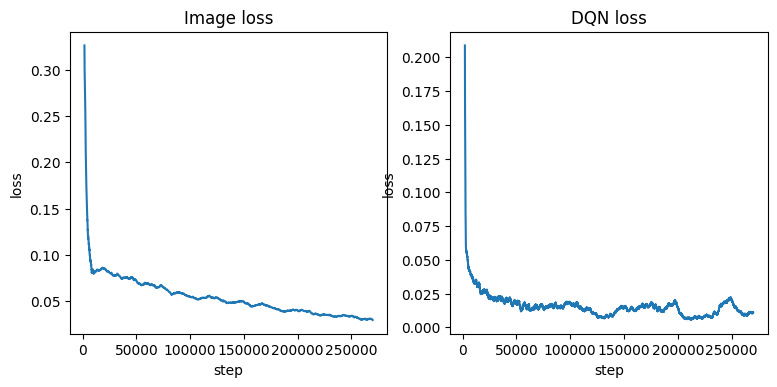

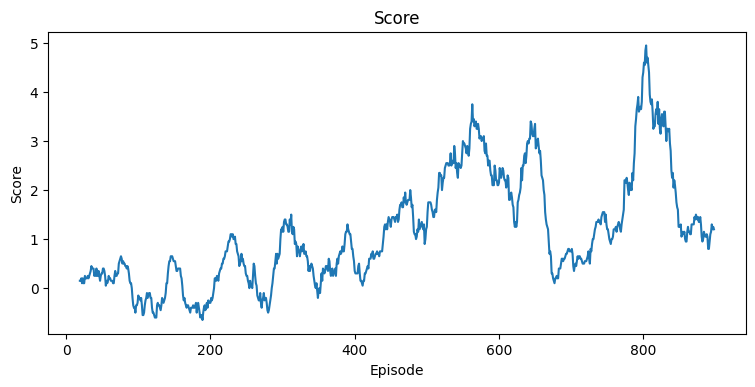

In [8]:
fig, axes = plt.subplots(1,2, figsize=(9,4), dpi=100)

img_loss_smoothed = pd.Series(agent.record_loss_image.values()).rolling(window=50).mean()
axes[0].plot(
    list(agent.record_loss_image.keys()),
    list(img_loss_smoothed)
)
axes[0].set_title('Image loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('step')

loss_smoothed = pd.Series(agent.record_loss.values()).rolling(window=200).mean()
axes[1].plot(
    list(agent.record_loss.keys()),
    list(loss_smoothed)
)
axes[1].set_title('DQN loss');
axes[1].set_ylabel('loss')
axes[1].set_xlabel('step')
plt.show()

scores_smoothed = pd.Series(scores).rolling(window=20).mean()
fig, ax = plt.subplots(1,1, figsize=(9,4), dpi=100)
ax.plot(scores_smoothed)
ax.set_title('Score')
ax.set_ylabel('Score')
ax.set_xlabel('Episode')
plt.show();

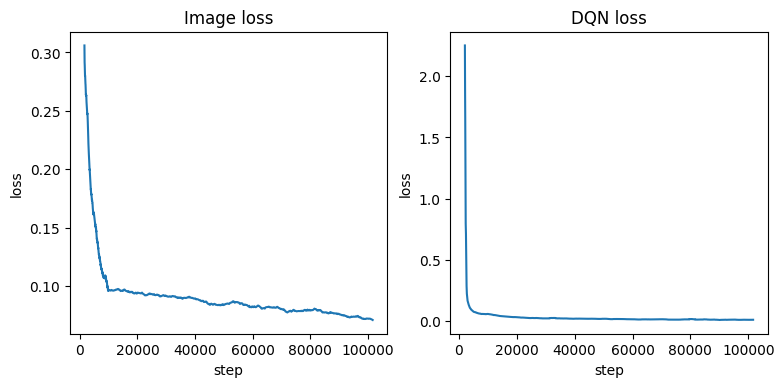

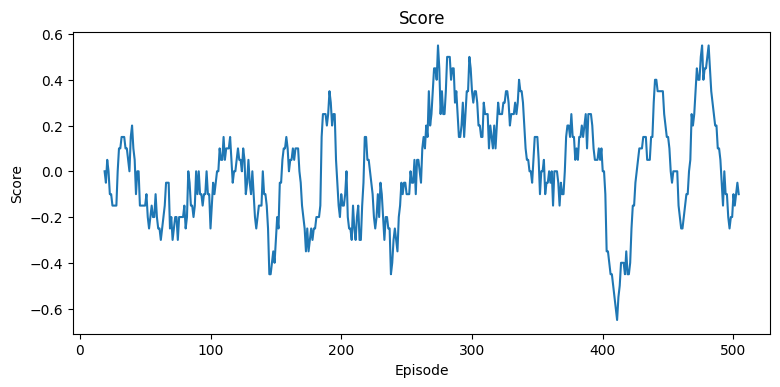

In [7]:
fig, axes = plt.subplots(1,2, figsize=(9,4), dpi=100)

img_loss_smoothed = pd.Series(agent.record_loss_image.values()).rolling(window=50).mean()
axes[0].plot(
    list(agent.record_loss_image.keys()),
    list(img_loss_smoothed)
)
axes[0].set_title('Image loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('step')

loss_smoothed = pd.Series(agent.record_loss.values()).rolling(window=200).mean()
axes[1].plot(
    list(agent.record_loss.keys()),
    list(loss_smoothed)
)
axes[1].set_title('DQN loss');
axes[1].set_ylabel('loss')
axes[1].set_xlabel('step')
plt.show()

scores_smoothed = pd.Series(scores).rolling(window=20).mean()
fig, ax = plt.subplots(1,1, figsize=(9,4), dpi=100)
ax.plot(scores_smoothed)
ax.set_title('Score')
ax.set_ylabel('Score')
ax.set_xlabel('Episode')
plt.show();

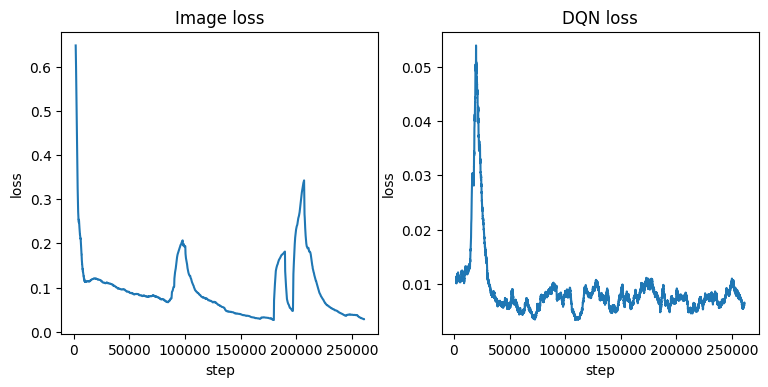

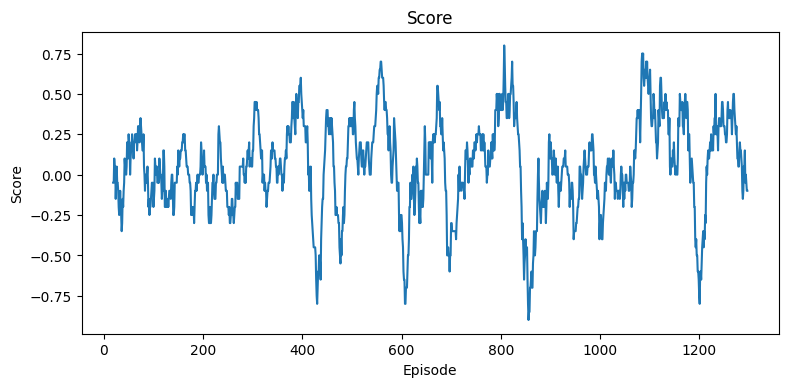

In [14]:
fig, axes = plt.subplots(1,2, figsize=(9,4), dpi=100)

img_loss_smoothed = pd.Series(agent.record_loss_image.values()).rolling(window=50).mean()
axes[0].plot(
    list(agent.record_loss_image.keys()),
    list(img_loss_smoothed)
)
axes[0].set_title('Image loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('step')

loss_smoothed = pd.Series(agent.record_loss.values()).rolling(window=200).mean()
axes[1].plot(
    list(agent.record_loss.keys()),
    list(loss_smoothed)
)
axes[1].set_title('DQN loss');
axes[1].set_ylabel('loss')
axes[1].set_xlabel('step')
plt.show()

scores_smoothed = pd.Series(scores).rolling(window=20).mean()
fig, ax = plt.subplots(1,1, figsize=(9,4), dpi=100)
ax.plot(scores_smoothed)
ax.set_title('Score')
ax.set_ylabel('Score')
ax.set_xlabel('Episode')
plt.show();

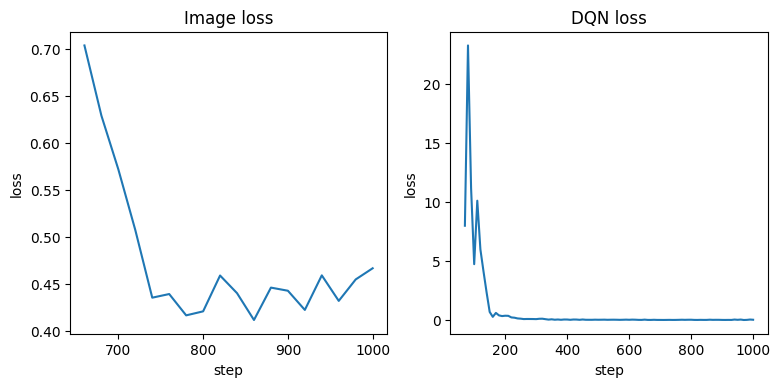

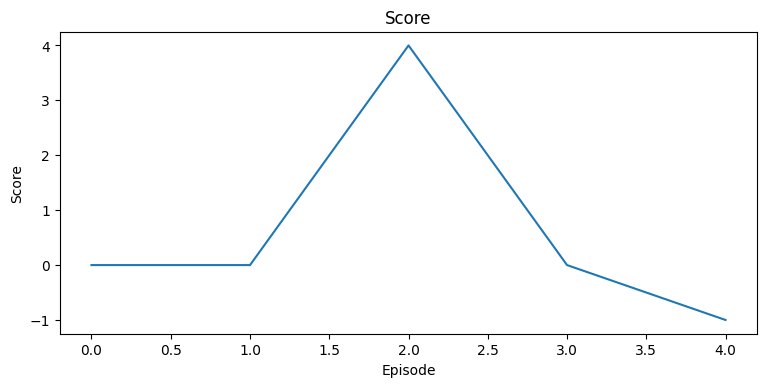

In [16]:
fig, axes = plt.subplots(1,2, figsize=(9,4), dpi=100)

axes[0].plot(
    list(agent.record_loss_image.keys()),
    list(agent.record_loss_image.values())
)
axes[0].set_title('Image loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('step')

axes[1].plot(
    list(agent.record_loss.keys()),
    list(agent.record_loss.values())
)
axes[1].set_title('DQN loss');
axes[1].set_ylabel('loss')
axes[1].set_xlabel('step')
plt.show()


fig, ax = plt.subplots(1,1, figsize=(9,4), dpi=100)
ax.plot(scores)
ax.set_title('Score')
ax.set_ylabel('Score')
ax.set_xlabel('Episode')
plt.show();

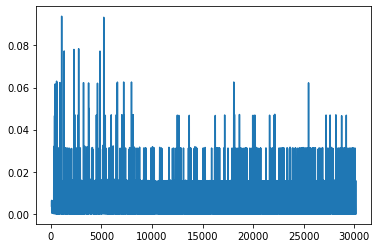

In [12]:
#print(agent.record_action)

plt.plot(
    list(agent.record_loss.keys()),
    list(agent.record_loss.values())
)

In [18]:
np.convolve([1, 2, 3, 4, 5, 6], [1,1,1], mode='valid')

array([ 6,  9, 12, 15])

In [19]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

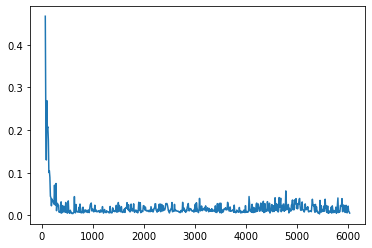

In [15]:
plt.plot(
    list(agent.record_loss.keys()),
    list(agent.record_loss.values())
)

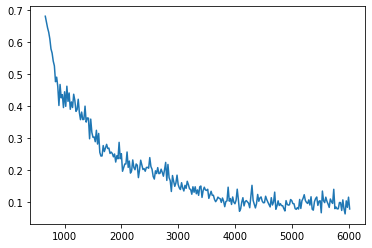

In [14]:
plt.plot(
    list(agent.record_loss_image.keys()),
    list(agent.record_loss_image.values())
)

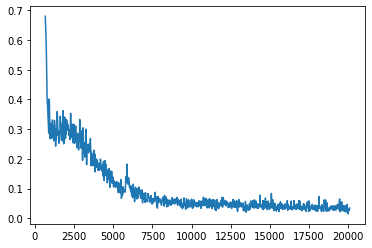

In [7]:
plt.plot(
    list(agent.record_loss_image.keys()),
    list(agent.record_loss_image.values())
)

In [29]:
pd.Series(list(agent.record_action.values())[150:220]).value_counts(normalize=True)

2    0.342857
1    0.271429
0    0.214286
3    0.171429
dtype: float64

In [ ]:
sample_size = 10
images, labels = agent.image_buffer.sample(sample_size)
preds_torch = agent.auxiliary_network(images)
preds = np.round(preds_torch .detach().numpy(),3)
loss_total = agent.criterion_aux(preds_torch, labels).item()

print(loss_total)
for _idx in range(sample_size):
    label = labels[_idx]
    pred = preds[_idx]
    np_image = to_np_image(images[_idx])
    loss = agent.criterion_aux(torch.unsqueeze(preds_torch[_idx], dim=0), torch.unsqueeze(label, dim=0)).item()
    
    plt.imshow(np_image)
    plt.show();
    print(label.numpy())
    print(pred)
    print(loss)

In [74]:
conv.out_channels

4

In [80]:
def compute_output_size(body, img_size, n_channels):
    
    for layer in body.children():
        img_size, n_channels = compute_out_img_size(layer, img_size, n_channels)
        
    return img_size **2 * n_channels

def compute_out_img_size(layer, width, n_channels):
    """Count the dimension of the output of a image layer"""
    kernel = layer.kernel_size if isinstance(layer.kernel_size, int) else layer.kernel_size[0]
    stride = layer.stride if isinstance(layer.stride, int) else layer.stride[0]

    size_img = floor((width - kernel) / stride + 1)
    
    if hasattr(layer, "out_channels"):
        n_channels = layer.out_channels
        
    return size_img, n_channels

In [20]:
img, label = agent.image_buffer.sample(1)
print(img.size())

torch.Size([1, 3, 84, 84])


In [79]:
compute_output_size(conv, 84, 3)

2888

In [67]:
conv = agent.q_network_local.body.conv1
mp = agent.q_network_local.body.mp1

conv2 = agent.q_network_local.body.conv2
mp2 = agent.q_network_local.body.mp2

In [47]:
compute_out_img_size(conv, img.size()[2])

80

In [69]:
19 * 19 * 8

2888

In [68]:
mp2(conv2(mp(conv(img)))).size()

torch.Size([1, 8, 19, 19])

In [23]:
conv(img)

tensor([[[[ 0.1138,  0.1138,  0.1138,  ...,  0.1138,  0.1138,  0.1138],
          [ 0.1138,  0.1138,  0.1138,  ...,  0.1138,  0.1138,  0.1138],
          [ 0.1138,  0.1138,  0.1138,  ...,  0.1138,  0.1138,  0.1138],
          ...,
          [ 0.0919,  0.0919,  0.0919,  ...,  0.0910,  0.0910,  0.0910],
          [ 0.0887,  0.0887,  0.0887,  ...,  0.0890,  0.0890,  0.0890],
          [ 0.0913,  0.0913,  0.0913,  ...,  0.0918,  0.0918,  0.0918]],

         [[-0.3583, -0.3583, -0.3583,  ..., -0.3583, -0.3583, -0.3583],
          [-0.3583, -0.3583, -0.3583,  ..., -0.3583, -0.3583, -0.3583],
          [-0.3583, -0.3583, -0.3583,  ..., -0.3583, -0.3583, -0.3583],
          ...,
          [-0.3573, -0.3573, -0.3573,  ..., -0.3628, -0.3628, -0.3628],
          [-0.3590, -0.3590, -0.3590,  ..., -0.3628, -0.3628, -0.3628],
          [-0.3556, -0.3556, -0.3556,  ..., -0.3597, -0.3597, -0.3597]],

         [[-0.7751, -0.7751, -0.7751,  ..., -0.7751, -0.7751, -0.7751],
          [-0.7751, -0.7751, -

_____________________
#### Debug du labelizer

1.0536445021629333


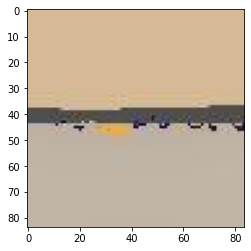

[0. 0. 0. 0. 0. 0.]
[0.016 0.071 0.036 0.078 0.022 0.251]
-0.0


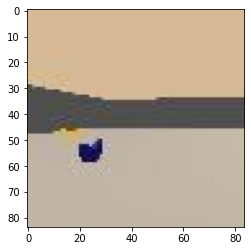

[0. 0. 0. 1. 0. 0.]
[0.011 0.003 0.    1.    0.871 0.004]
1.2110395431518555


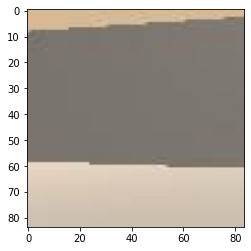

[0. 0. 0. 0. 0. 0.]
[0.82  0.189 0.264 0.005 0.002 0.229]
-0.0


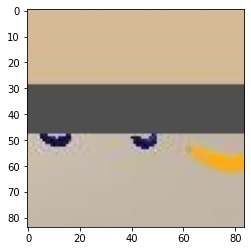

[0. 0. 1. 1. 1. 0.]
[0.    0.    1.    0.991 0.984 0.   ]
4.242403745651245


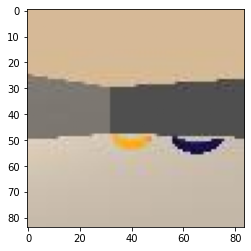

[0. 1. 0. 0. 0. 1.]
[0.001 0.829 0.002 0.    0.    1.   ]
2.567923903465271


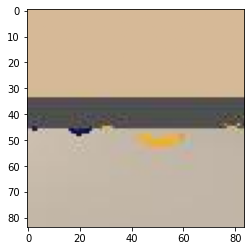

[0. 0. 0. 1. 0. 0.]
[0.002 0.959 0.096 0.705 0.007 0.022]
1.4659817218780518


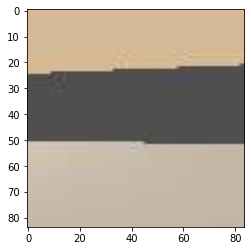

[0. 0. 0. 0. 0. 0.]
[0.521 0.005 0.154 0.005 0.035 0.393]
-0.0


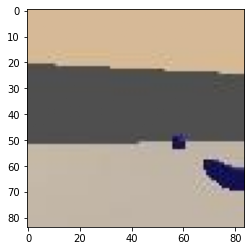

[0. 0. 0. 0. 0. 1.]
[0.027 0.002 0.001 0.    0.012 1.   ]
1.0490961074829102


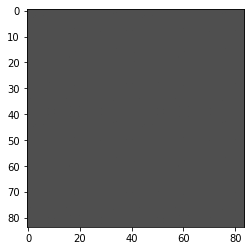

[0. 0. 0. 0. 0. 0.]
[0.832 0.206 0.346 0.013 0.005 0.163]
-0.0


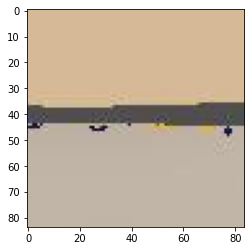

[0. 0. 0. 0. 0. 0.]
[0.011 0.009 0.023 0.361 0.07  0.372]
-0.0


In [36]:
sample_size = 10
images, labels = agent.image_buffer.sample(sample_size)
preds_torch = agent.auxiliary_network(images)
preds = np.round(preds_torch .detach().numpy(),3)
loss_total = agent.criterion_aux(preds_torch, labels).item()

print(loss_total)
for _idx in range(sample_size):
    label = labels[_idx]
    pred = preds[_idx]
    np_image = to_np_image(images[_idx])
    loss = agent.criterion_aux(torch.unsqueeze(preds_torch[_idx], dim=0), torch.unsqueeze(label, dim=0)).item()
    
    plt.imshow(np_image)
    plt.show();
    print(label.numpy())
    print(pred)
    print(loss)

#### One episode no buffer.

In [25]:
%%time

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    

score, step, last_action = 0, 0 ,0

for i in range(1):
    
    action = select_action(last_action)
    last_action = action
    
    env_info = env.step(action)[brain_name]      
    next_state = env_info.visual_observations[0] 
    reward = env_info.rewards[0]                 
    done = env_info.local_done[0]                
    
    score += reward                               
    state = next_state  
    step += 1
    
    # step
    
    colors_labels_np = labelizer(state)
    colors_labels = torch.from_numpy(colors_labels_np).float()
    color_pred = aux_net(state_torch)
    

Wall time: 123 ms


In [29]:
%%time

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    

score, step, last_action = 0, 0 ,0

while True:
    
    action = select_action(last_action)
    last_action = action
    
    env_info = env.step(action)[brain_name]      
    next_state = env_info.visual_observations[0] 
    reward = env_info.rewards[0]                 
    done = env_info.local_done[0]                
    
    score += reward                               
    state = next_state  
    step += 1
    
    # step
    state_torch = torch.from_numpy(np.moveaxis(state, 3, 1)).float()
    
    colors_labels = torch.from_numpy(labelizer(state)).float()
    color_pred = aux_net(state_torch)
    
    optimizer_aux.zero_grad()
    loss_color_detection = criterion_aux(color_pred, colors_labels)
    loss_color_detection.backward()
    optimizer_aux.step()
    
    if (done | step > 100):                                      
        break
    
print("Score: {}".format(score))

Score: -1.0
Score: -1.0
Score: 0.0
Score: 0.0
Score: -1.0
Score: -1.0
Score: 2.0
Score: 0.0
5.14 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### One episode with buffer.

In [107]:
%%time

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]    

score, step, last_action = 0, 0 ,0
color_labels = []
colors_pred = []


while True:
    
    action = select_action(last_action)
    last_action = action
    
    env_info = env.step(action)[brain_name]      
    next_state = env_info.visual_observations[0] 
    reward = env_info.rewards[0]                 
    done = env_info.local_done[0]                
    
    score += reward                               
    state = next_state  
    step += 1
    
    # step
    state_torch = torch.from_numpy(np.moveaxis(state, 3, 1)).float()
    
    yellow_labels, blue_labels = labelizer(torch.squeeze(state_torch))
    colors_labels = torch.from_numpy(np.concatenate((yellow_labels, blue_labels))).float()
    color_pred = aux_net(state_torch)

    if (done | step > 100):                                      
        break
    
print("Score: {}".format(score))

Score: 1.0
Wall time: 4.35 s


#### 2000 episodes color detection performances

In [143]:
%%time

N_EPISODES = 2_000

errors_color_detection = []
scores = []

for i in tqdm(range(1, N_EPISODES + 1)):
    
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.visual_observations[0]    
    score, step, last_action = 0, 0 ,0
    errors_color_detection_episode = []
    
    while True:
        
        action = select_action(last_action)
        last_action = action
        
        env_info = env.step(action)[brain_name]      
        next_state = env_info.visual_observations[0] 
        reward = env_info.rewards[0]                 
        done = env_info.local_done[0]                
        
        score += reward                               
        state = next_state  
        step += 1
        
        # step
        state_torch = torch.from_numpy(np.moveaxis(state, 3, 1)).float()
        
        yellow_labels, blue_labels = labelizer(torch.squeeze(state_torch))
        colors_labels = torch.from_numpy(np.concatenate((yellow_labels, blue_labels)).reshape(1,-1)).float()
        color_pred = aux_net(state_torch)
        print(color_pred)
        
        optimizer_aux.zero_grad()
        loss_color_detection = criterion_aux(color_pred, colors_labels)
        loss_color_detection.backward()
        optimizer_aux.step()
        errors_color_detection_episode.append(loss_color_detection.item())
        
        if (done | step > 100):
            scores.append(score)
            errors_color_detection.append(np.mean(errors_color_detection_episode))
            break

100%|██████████| 2000/2000 [2:54:17<00:00,  5.23s/it]  

Wall time: 2h 54min 17s


______

##### Debug

In [114]:
a = np.array([
    [
        [111, 112, 113, 114],
        [121, 122, 123, 124],
        [131, 132, 133, 134],
    ],
    [
        [211, 212, 213, 214],
        [221, 222, 223, 224],
        [231, 232, 233, 234]
    ]
])
print(a.shape)

(2, 3, 4)


__________

### Figures

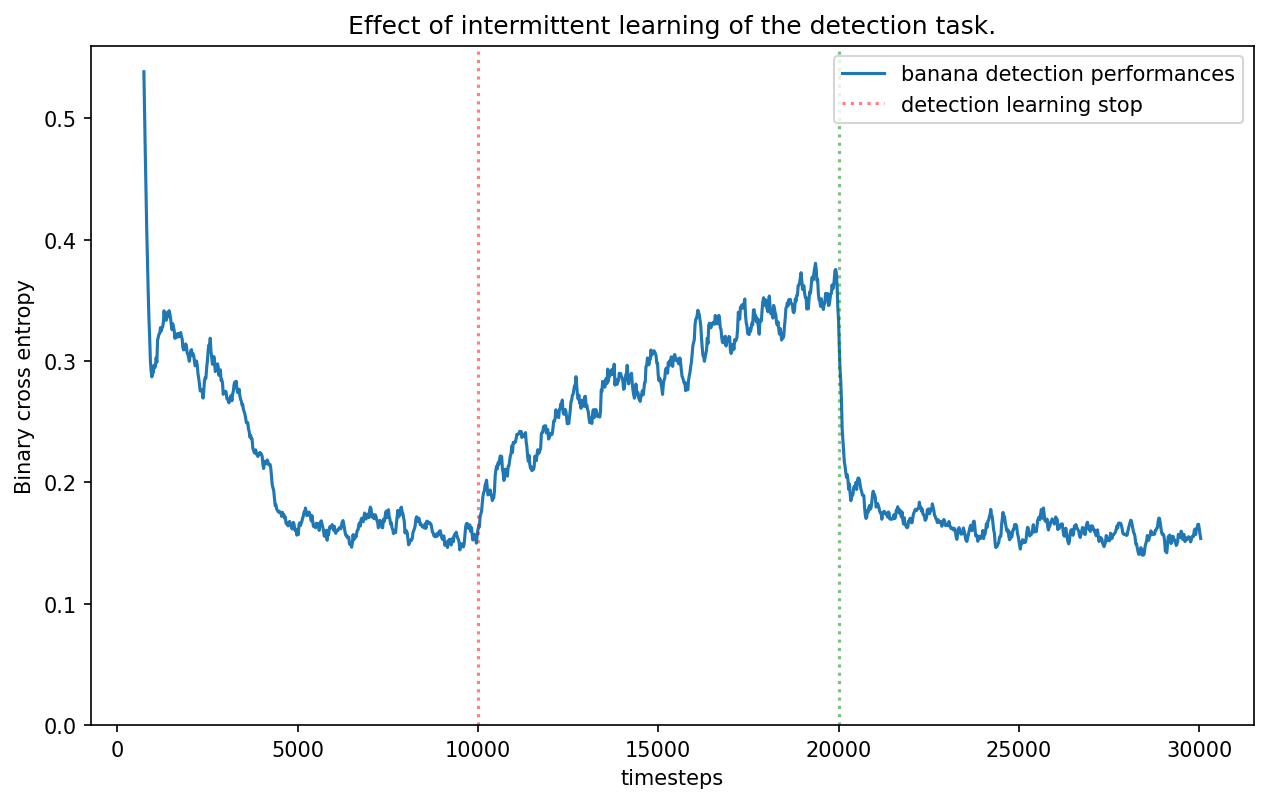

In [58]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(10,6))

t_steps = list(agent.record_loss_image.keys())
losses = list(agent.record_loss_image.values())

ax.plot(t_steps[4: -5], np.convolve(losses, np.ones(10) / 10, mode='valid'), label="banana detection performances")
ax.axvline(x=10_000, alpha=.5, linestyle=':', color='r', label='detection learning stop')
ax.axvline(x=20_000, alpha=.5, linestyle=':', color='g')

ax.set_ylim((0,.56)) 

ax.set_ylabel('Binary cross entropy')
ax.set_xlabel('timesteps')
ax.set_title('Effect of intermittent learning of the detection task.')
ax.legend()
plt.savefig(os.path.join(PATH_OUPUT_IMAGE, f'bananas_detection_performances.png'));

In [59]:
plt.savefig(os.path.join(PATH_OUPUT_IMAGE, f'bananas_detection_performances.png'))

<Figure size 432x288 with 0 Axes>